In [1]:
# Set up the SDR
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr
# Close previous instances of the sdr object
try:
    sdr.close()
except NameError:
   pass


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
import threading
import time

%matplotlib inline


In [5]:
# sdr = RtlSdr()

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [23]:
# sdr.close()

In [7]:
# sdr.valid_gains_db

[0.0,
 0.9,
 1.4,
 2.7,
 3.7,
 7.7,
 8.7,
 12.5,
 14.4,
 15.7,
 16.6,
 19.7,
 20.7,
 22.9,
 25.4,
 28.0,
 29.7,
 32.8,
 33.8,
 36.4,
 37.2,
 38.6,
 40.2,
 42.1,
 43.4,
 43.9,
 44.5,
 48.0,
 49.6]

Text(0.5, 0, 'samples')

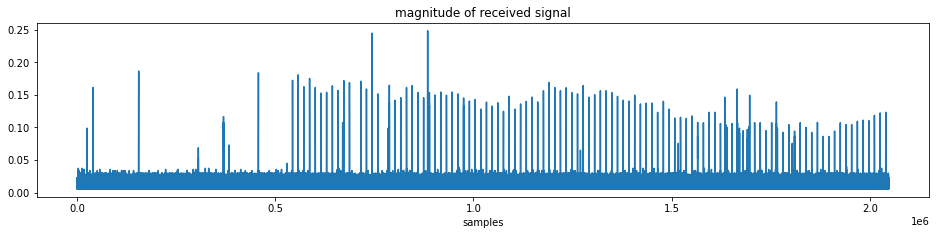

In [25]:
# sdr.close()

# fs = 1e6
# f0 = 88.4e6
# sdr = RtlSdr()
# sdr.set_sample_rate(2000000)    # sampling rate
# sdr.set_center_freq(1090e6) 

# gain = sdr.valid_gains_db[len(sdr.valid_gains_db)//2 + 2]


# N_samples = 2048000  # approximately 2 seconds
# y = sdr.read_samples(N_samples)   # get samples
y = np.load("adsb.npy")

# samples = y[0:8000]

# windowed_y = np.kaiser(len(samples), 6)*samples

# Y_w = np.fft.fft( windowed_y )
# Y_w = np.fft.fftshift(Y_w)
# f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y_w))

# # Plot
# width, height = figaspect(0.2)
# fig=plt.figure(figsize=(width,height))
# plt.semilogy( f/1e6, abs(Y_w)), plt.xlabel('frequency [MHz]');
# plt.title('spectrum');


# Plotting code
width, height = figaspect(0.2)
fig = figure(figsize=(width, height))
plot(abs(y))
title('magnitude of received signal')
xlabel('samples')

# sdr.close()

In [10]:
fs = 2000000
newy = abs(y) / max(abs(y))

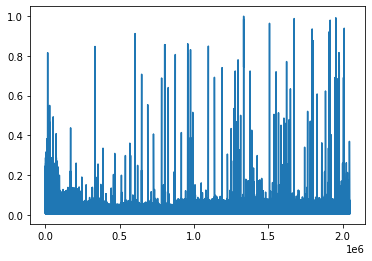

In [11]:
plot(newy)

KeyboardInterrupt: 

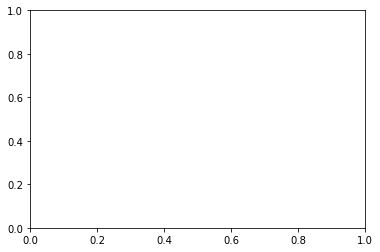

In [14]:
plt.stem(abs(newy))

<StemContainer object of 3 artists>

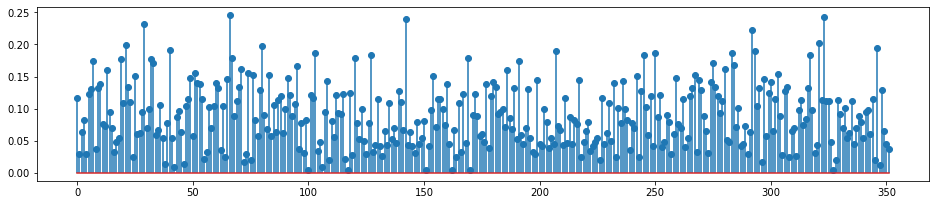

In [15]:
idx = 0
chunk_length = 112 * 3 + 16

y_chunk = newy[idx: idx + chunk_length] 

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.stem( abs(y_chunk ) )

In [18]:
decoded = np.array([1 if y_chunk[2*i+1] < y_chunk[2*i]
                   else 0 for i in range(len(y_chunk)//2)])

# plot the bits
len(decoded)


176

In [17]:
y_median = np.median(newy)
y_mad = np.median(abs(newy - y_median))
y_std = 1.4826*y_mad

print(y_median)
print(y_mad)
print(y_std)

0.019839864005023265
0.007935945602009354
0.011765832949539068


In [26]:
import scipy.stats